In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from typing import List
import os 

In [ ]:

def load_covid_data(filename: str) -> pd.DataFrame:
    """ 
    Loads and preprocesses a COVID-19 dataset into a total cases by country for a given series of dates
    
    Transformations made are: 
        1. Dropping an unnecessary row (State/Province)
        2. Formatting and restoring the "date" column for later processing
        3. Calculating weekly and monthly sums by country, returning them with the original dataframe 
    
    
    Args: filename (str): Path to CSV file 
    
    Returns: pd.DataFrame: Processed data

    
    """
    
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")

    try:
        df = pd.read_csv(filename)
    except Exception as e:
        raise ValueError(f"Error reading CSV file: {e}")

    # Validate required column exists
    if "Country/Region" not in df.columns:
        raise ValueError("Expected column 'Country/Region' not found in dataset.")

    # Validate dataset not empty
    if df.empty:
        raise ValueError("The dataset is empty.")

    #  Drop province row safely
    if len(df) < 2:
        raise ValueError("Dataset does not contain enough rows to process.")
    df = df.drop(0).copy()

    #  Rename and convert Date column
    df = df.rename(columns={"Country/Region": "Date"})

    try:
        df["Date"] = pd.to_datetime(df["Date"])
    except Exception:
        raise ValueError("Date column could not be converted to datetime.")

    df = df.set_index("Date")

    # Clean duplicate column suffixes
    df.columns = df.columns.str.replace(r'\.\d+$', '', regex=True)

    # Convert values to numeric
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)

    # Aggregate duplicate country columns
    try:
        df = df.groupby(df.columns, axis=1).sum()
    except Exception:
        raise ValueError("Error aggregating duplicate country columns.")

    # 🔹 9. Ensure datetime index for resampling
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Index must be DatetimeIndex for resampling.")

    weekly = df.resample("W").sum()
    monthly = df.resample("M").sum()

    monthly.index = monthly.index.to_period("M")

    # 🔹 10. Save outputs safely
    try:
        weekly.to_csv("weekly_cases.csv", index=True)
        monthly.to_csv("monthly_cases.csv", index=True)
    except Exception as e:
        print(f"Warning: Could not save CSV files: {e}")

    return df, weekly, monthly




load_covid_data('/Users/bencerbin/Desktop/CS Shit/DataViz/global_confirmed_cases.csv')

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:43: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:57: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:66: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



(            Afghanistan  Albania  Algeria  Andorra  Angola  Antarctica  \
 Date                                                                     
 2020-01-23          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-01-24          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-01-25          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-01-26          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-01-27          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-01-28          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-01-29          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-01-30          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-01-31          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-02-01          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-02-02          0.0      0.0      0.0      0.0     0.0         0.0   
 2020-02-03          0.0 

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:43: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:57: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:66: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



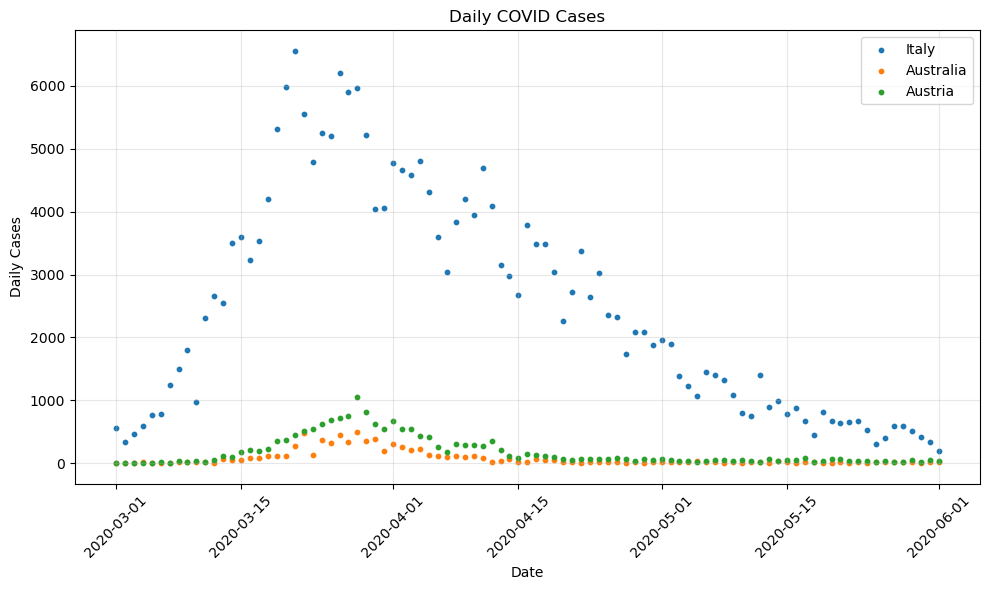

In [ ]:
def create_daily_cases_scatter(
    data: pd.DataFrame,
    countries: List[str],
    start_date: str,
    end_date: str) -> plt.Figure:
    
    """ 
    Create scatter plot of daily COVID cases
    
    Args:
        data: cleaned COVID data
        countries: List of countries to be included
        start_date: Starting data
        end_date: Ending date
    
    """
    
    if data.empty:
        raise ValueError("Input DataFrame is empty.")
    
    if start > end or start < data.index.min() or end > data.index.max():
        raise ValueError("dates are out of bounds")
    

    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
        
    filtered = data.loc[start:end]
        
    fig, ax = plt.subplots(figsize=(10,6))

        
    for country in countries:
        if country in filtered.columns:
            ax.scatter(filtered.index, filtered[country], label=country, s=10)
        else:
            raise ValueError(f"{country} not in dataset")
        
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily Cases")
    ax.set_title("Daily COVID Cases")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.tick_params(axis="x", rotation=45)

    fig.tight_layout()
    plt.show()

data,monthly,weekly = load_covid_data('/Users/bencerbin/Desktop/CS Shit/DataViz/global_confirmed_cases.csv')
start_date = "2020-03-01"
end_date = "2020-06-01"


create_daily_cases_scatter(data, ["Italy", "Australia", "Austria"], start_date, end_date)

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:43: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:57: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:66: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



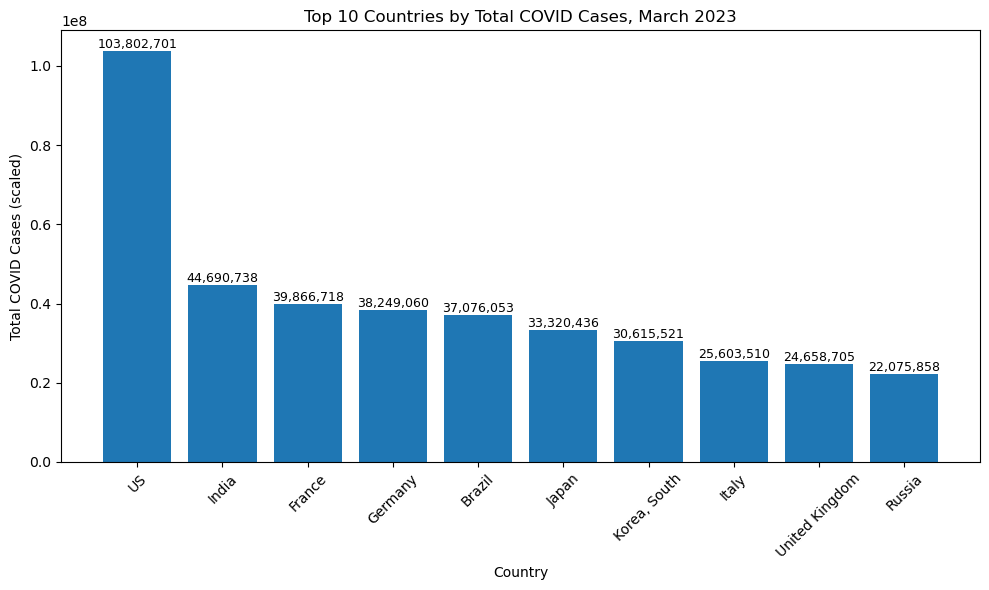

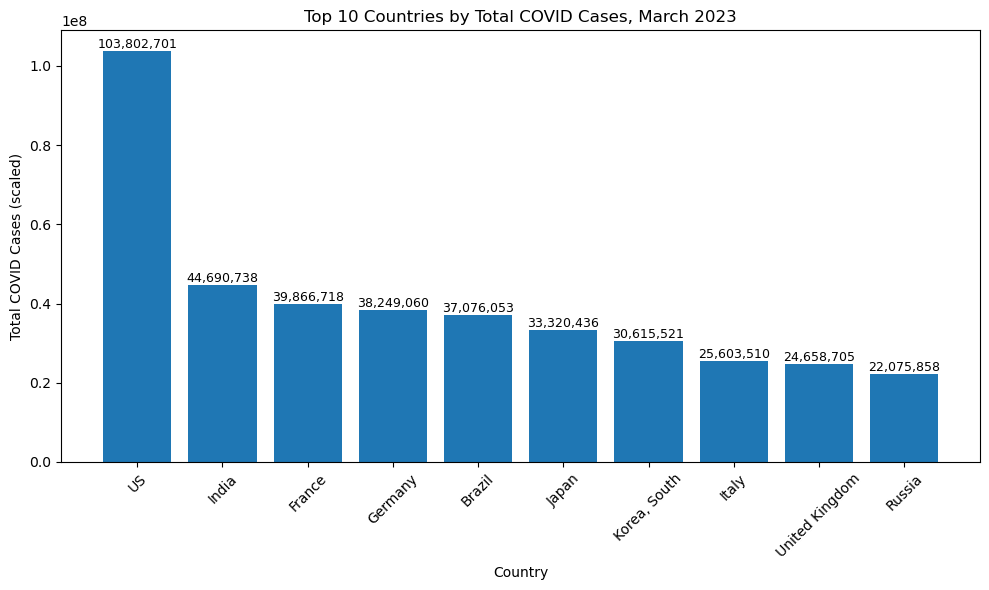

In [116]:
def create_total_cases_bar(
    data: pd.DataFrame,
    n_countries: int = 10 
) -> plt.Figure:
    
    """ 
    Create bar chart of total cases by country
    
    Args:
        data: COVID data (assuming already cleaned via load_covid_data)
        n_countries: Number of top countries to show
        
    Returns:
        plt.Figure: Matplotlib figure
    
    """
    
    totals = data.sum()
    
    top_countries = totals.sort_values(ascending=False).head(n_countries) 
     
    
    last_date = data.index.max()
    last_date_str = last_date.strftime("%B %Y")
    
    fig, ax = plt.subplots(figsize=(10,6)) 
    
    bars = ax.bar(top_countries.index, top_countries.values)
    ax.set_xlabel("Country")
    ax.set_ylabel("Total COVID Cases (scaled)")
    ax.set_title(f"Top {n_countries} Countries by Total COVID Cases, {last_date_str}")
    ax.tick_params(axis="x", rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height):,}",
            ha='center',
            va='bottom',
            fontsize = 9
                )
        
    
    fig.tight_layout()

    return fig
    

data,monthly,weekly = load_covid_data('/Users/bencerbin/Desktop/CS Shit/DataViz/global_confirmed_cases.csv')

create_total_cases_bar(data, 10)

In [117]:
def create_interactive_trends(
    data: pd.DataFrame,
    countries: List[str]
) -> go.Figure:
    
    """ 
    Create interactive time series plot.
    
    Args:
        data: COVID data
        countries: Countries to include
        
        
    Returns:
        go.Figure: Plotly figure 
    
    """
    
    
    missing = [c for c in countries if c not in data.columns]

    if missing:
        raise ValueError(f"The following countries are not in the dataset: {missing}")
    
    fig = go.Figure()
    
    for country in countries:
        fig.add_trace(
            go.Scatter(
                x=data.index,
                y=data[country],
                mode="lines",
                name=country,
                
            )
        )
        
    fig.update_layout(
        title="Interactive COVID-19 Trends",
        xaxis_title ="Date",
        yaxis_title ="Daily Cases",
        yaxis_tickformat=",",
        hovermode ="x unified",
        template = "plotly_white"
    )
    
    return fig

data,monthly,weekly = load_covid_data('/Users/bencerbin/Desktop/CS Shit/DataViz/global_confirmed_cases.csv')

create_interactive_trends(data, ["Italy", "Australia", "Austria"])

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:43: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:57: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:66: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import plotly.express as px


def create_country_comparison(
    data: pd.DataFrame,
    metric: str = "total_cases"
) -> go.Figure:

    """ 
    Creates an interactive country comparison,
    allowing for users to select countries
    from a dropdown menu and add them to the visualization
    
    Args:
        data: COVID data
        metric: comparison metric 
        
    Returns:
        go.Figure: Plotly figure
    
    
    """

    if data is None or data.empty:
        raise ValueError("Input DataFrame is empty.")
    
    if metric != "total_cases":
        raise ValueError("Currently only 'total_cases' metric is supported.")


    # Calculate date for app header

    last_date = data.index.max()
    last_date_str = last_date.strftime("%B %Y")

    # ---------------------------------------------------
    # Initialize Dash app
    # ---------------------------------------------------

    app = dash.Dash(__name__)

    # ---------------------------------------------------
    # HTML and Styling for the Dashboard
    # ---------------------------------------------------

    app.layout = html.Div([
        html.Div([
            html.H1(f"COVID-19 TOTAL CASES BY COUNTRY, {last_date_str}",
                    style={"textAlign": "center"})
        ]),

        html.Div([
            html.Label("Select Countries:",
                    style={"fontWeight": "bold"}),
            dcc.Dropdown(
                id='country-dropdown',
                options=[{'label': c, 'value': c} for c in data.columns],
                value=[data.columns[0]],
                multi=True
            )
        ], style={"width": "50%", "margin": "auto"}),

        html.Div([
            dcc.Graph(id='interactive-country-comparison')
        ], style={"paddingTop": "30px",
                "boxShadow": "0px 4px 12px rgba(0,0,0,0.1)",
                "borderRadius": "20px"})
    ],
    style={
        "backgroundColor": "#B3BCC9",
        "padding": "40px",
        "borderRadius": "16px",
        "boxShadow": "0 12px 24px rgba(0,0,0,0.05)"
    })


    # ---------------------------------------------------
    # Callback
    # ---------------------------------------------------

    @app.callback(
        Output('interactive-country-comparison', 'figure'),
        Input('country-dropdown', 'value')
    )
    
    def update_bar_chart(selected_countries):

        if not selected_countries:
            return go.Figure()

        #Sort selected countries, compile into totals
        totals = data[selected_countries].sum().sort_values(ascending=False)



        #Create figure and add data based on totals
        fig = go.Figure()
        fig.add_trace(
            go.Bar(
                x=totals.index,
                y=totals.values,
                marker=dict(
                    color=totals.values,
                    colorscale="YlOrRd"
                ),
                hovertemplate=
                    "<b>%{x}</b><br>" +
                    "Total Cases: %{y:,.0f}<extra></extra>"
            )
        )

        fig.update_layout(
            template="plotly_white",
            title=dict(
                text="Total COVID Cases by Selected Countries",
                x=0.5,
                xanchor="center"
            ),
            xaxis_title="Country",
            yaxis_title="Total Cases",
            font=dict(
                family="Arial",
                size=14
            ),
            margin=dict(l=40, r=40, t=80, b=80)
    )


        return fig


    # ---------------------------------------------------
    # Run App
    # ---------------------------------------------------

    if __name__ == '__main__':
        app.run_server(debug=True, port=8051)


data, monthly, weekly = load_covid_data(
    '/Users/bencerbin/Desktop/CS Shit/DataViz/global_confirmed_cases.csv'
)

create_country_comparison(data, "total_cases")

        

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:43: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:57: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/r1/bpqfjgh13vggys379csnksbc0000gn/T/ipykernel_31627/2657764791.py:66: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

